In [1]:
import scipy.io as sio
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import time
import sys
import glob
import hdf5storage
from random import shuffle
import time
import os
import json
import cv2
import pandas as pd

In [2]:
def functionfilenameandpath(path='./',extension='.csv'):
    # Path is the path where you want to search

    # this is the extension you want to detect


    filepaths=[]
    filenames=[]

    # print(path)

    for root, dirs_list, files_list in os.walk(path):
        # print("root",root)
        # print("dirs_list",dirs_list)
        # print("files_list",files_list)
        for file_name in files_list:
            if os.path.splitext(file_name)[-1] == extension:
                file_name_path = os.path.join(root, file_name)
                # if(file_name.find('Home')!=-1):
                #     filenames.append(file_name)
                #     filepaths.append(file_name_path)
                filenames.append(file_name)
                filepaths.append(file_name_path)
                # print(file_name)
                # print(file_name_path)   # This is the full path of the filter file

   
    return filenames,filepaths




def compute_jmatrix_label(frame_number, json_file_name="alphapose-videoslice30-results.json"):
    # Opening JSON file
    f = open(json_file_name)


    # returns JSON object as 
    # a dictionary
    data = json.load(f)


    # Closing file
    f.close()
    frame=str(frame_number)+".jpg"

    xyc=data[frame]["people"][0]["pose_keypoints_2d"].copy()

    jointsvectorx=[]
    jointsvectory=[]
    jointsvectorc=[]
    i=0
    while(i<len(xyc)):
        jointsvectorx.append(xyc[i])
        i=i+1
        jointsvectory.append(xyc[i])
        i=i+1
        jointsvectorc.append(xyc[i])
        i=i+1
        if(i==(len(xyc))):
            break
    n = 18
    m = 18
    jointsmatrixx=[[10] * m for i in range(n)]
    jointsmatrixy=[[10] * m for i in range(n)]
    jointsmatrixc=[[10] * m for i in range(n)]

    for r in range(18):
        for c in range(18):
            if r==c:
                jointsmatrixx[r][c]=jointsvectorx[r]
                jointsmatrixy[r][c]=jointsvectory[r]
                jointsmatrixc[r][c]=jointsvectorc[r]
            else:
                jointsmatrixx[r][c]=jointsvectorx[r]-jointsvectorx[c]
                jointsmatrixy[r][c]=jointsvectory[r]-jointsvectory[c]
                jointsmatrixc[r][c]=jointsvectorc[r]*jointsvectorc[c]
    
    matx=np.array(jointsmatrixx)
    maty=np.array(jointsmatrixy)
    matc=np.array(jointsmatrixc)
    jointsmatrix=np.stack((matx,maty,matc,matc),axis=0)

    jointsvector=jointsvectorx+jointsvectory+jointsvectorc+jointsvectorc
    jointsvector=np.array(jointsvector)



    jmatrix_label_mod = torch.zeros(1, 4, 18, 18)
    jmatrix_label_mod[0, :, :, :] = torch.from_numpy(jointsmatrix).type(torch.FloatTensor)
    #print(jmatrix_label_mod.shape)

    return jmatrix_label_mod




def return_dict_for_each_session(session_no=0):
    
    csi_np=np.load(csi_filepaths[session_no],allow_pickle=True)
    data_dict={}
    data_dict_list=[]
    vd_ts=pd.read_csv(vd_ts_filepaths[session_no],names=["DateTime"])
    video_timestamps=vd_ts[:602].copy()

    vt_np=video_timestamps["DateTime"].to_list()

    set_list=[]

    jump_number=5
    i=0
    start_from=80
    index=0
    while(True):
        start_index=i*jump_number+start_from
        if start_index>(len(vt_np)-1):
            break

        
        x,y=csi_np.shape
        min=0
        for ct in range(x):
            t1=np.datetime64(vt_np[start_index])
            t2=np.datetime64(csi_np[ct][1])+np.timedelta64(11, 'h')

            if(t2<t1):
                min=ct
            if(t2-t1==0):
                min=ct
            if(t2>t1):
                break
        if(ct+1>x):
            break
        
        set_list.append([start_index,min-1,min,min+1])

        i=i+1

    
    torch.cuda.empty_cache()

    #print(set_list)
    for i in range(len(set_list)):
        data_dict={}
        csi_arr = csi_np[set_list[i][1]][2][0:50] + csi_np[set_list[i][2]][2][0:50] + csi_np[set_list[i][3]][2][0:50]
        csi_arr=np.array(csi_arr)[0:150]
        csi_arr=np.absolute(csi_arr)
        jmatrix_one=compute_jmatrix_label(set_list[i][0],pose_filepaths[session_no])
        frame=cv2.imread(video_filepaths[session_no].replace(".mp4","")+"/frame"+str(set_list[i][0])+".jpg")
        data_dict["csi_data"]=csi_arr
        data_dict["jmatrix"]=jmatrix_one
        data_dict["frame"]=frame
        data_dict["set_list"]=set_list[i]
        data_dict["Video_file_name"]=video_filenames[session_no]
        data_dict_list.append(data_dict)
    return data_dict_list
    

        
    

In [3]:
folderpath="./2023-03-01-Test1/"
vd_ts_filenames,vd_ts_filepaths=functionfilenameandpath(folderpath,'.txt')

vd_ts_filenames.sort()
vd_ts_filepaths.sort()
print(vd_ts_filenames)

folderpath="./2023-03-01-Test1/"
csi_filenames,csi_filepaths=functionfilenameandpath(folderpath,'.npy')

csi_filenames.sort()
csi_filepaths.sort()
print(csi_filenames)

folderpath="./2023-03-01-Test1/"
video_filenames,video_filepaths=functionfilenameandpath(folderpath,'.mp4')

video_filenames.sort()
video_filepaths.sort()
print(csi_filenames)


folderpath="./2023-03-01-Test1/"
pose_filenames,pose_filepaths=functionfilenameandpath(folderpath,'.json')

pose_filenames.sort()
pose_filepaths.sort()
print(pose_filenames)

['VideoTimestamp_Test1ArmsUp1643.txt', 'VideoTimestamp_Test2ArmsYShape1647.txt', 'VideoTimestamp_Test3ArmsLow1652.txt', 'VideoTimestamp_Test4NutralRight..txt', 'VideoTimestamp_Test5NutralLeft.txt', 'VideoTimestamp_Test6NutralCentre.txt', 'VideoTimestamp_Test7Sitting.txt', 'VideoTimestamp_Test8MultiPose..txt']
['CSI_Test1-ArmsUp1643.npy', 'CSI_Test2ArmsYShape1647.npy', 'CSI_Test3ArmsLow1652.npy', 'CSI_Test4NutralRight.npy', 'CSI_Test5NutralLeft.npy', 'CSI_Test6NutralCentre.npy', 'CSI_Test7Sitting.npy', 'CSI_Test8MultiPose.npy']
['CSI_Test1-ArmsUp1643.npy', 'CSI_Test2ArmsYShape1647.npy', 'CSI_Test3ArmsLow1652.npy', 'CSI_Test4NutralRight.npy', 'CSI_Test5NutralLeft.npy', 'CSI_Test6NutralCentre.npy', 'CSI_Test7Sitting.npy', 'CSI_Test8MultiPose.npy']
['AlphaPose_video_Test1ArmsUp1643.json', 'AlphaPose_video_Test2ArmsYShape1647.json', 'AlphaPose_video_Test3ArmsLow1652.json', 'AlphaPose_video_Test4NutralRight.json', 'AlphaPose_video_Test5NutralLeft.json', 'AlphaPose_video_Test6NutralCentre.jso

In [4]:
all_train_data=[]
for i in range(len(csi_filenames)):
    all_train_data+=(return_dict_for_each_session(i))

In [5]:
import scipy.io as sio
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
# import matplotlib.pyplot as plt
import math
import time
import sys
import glob
import hdf5storage
from random import shuffle
import time
import os
from IPython.display import clear_output
limb = np.array([[0,1],[0,14],[0,15],[14,16],[15,17],[1,2],[1,5],[1,8],[1,11],[2,3],[3,4],[5,6],[6,7],[8,9],[9,10],[11,12],[12,13]])


from models.wisppn_resnet import ResNet, ResidualBlock, Bottleneck

wisppn = ResNet(ResidualBlock, [2, 2, 2, 2])
# resnet = ResNet(ResidualBlock, [3, 4, 6, 3])
# resnet = ResNet(Bottleneck, [3, 4, 6, 3])
wisppn = wisppn.cuda()


num_epochs = 10
learning_rate = 0.01

criterion_L2 = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(wisppn.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7,10, 15, 20, 25, 30], gamma=0.5)

wisppn.train()
loss_list=[]

for epoch_index in range(num_epochs):
    
    start = time.time()
    total_csis=len(all_train_data)
    batch_size=8
    batch_num=int(total_csis/batch_size)
    t_index=0

    for batch_index in range(batch_num):

        jmatrix_label = torch.zeros(batch_size, 4, 18, 18)
        csi_data = torch.zeros(batch_size, 30*5, 1, 1)
        frame_list=[]
        print("Batch_index:",batch_index)
        for i in range(batch_size):
            csi_data[i,:,:,:]=torch.from_numpy(all_train_data[t_index]["csi_data"].reshape(150,1,1))
            jmatrix_label[i,:,:,:]=all_train_data[t_index]["jmatrix"]
            frame_list.append(all_train_data[t_index]["frame"])            
            t_index=t_index+1
       

        csi_data = Variable(csi_data.cuda())
        xy = Variable(jmatrix_label[:, 0:2, :, :].cuda())
        confidence = Variable(jmatrix_label[:, 2:4, :, :].cuda())

        pred_xy = wisppn(csi_data)
        loss = criterion_L2(torch.mul(confidence, pred_xy), torch.mul(confidence, xy))

        print(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append([loss.item(),batch_index,epoch_index])
        pred_xy_numpy=pred_xy.cpu().detach().numpy()

    scheduler.step()
    endl = time.time()
    print('Costing time:', (endl-start)/60)
    print("Epoch :" + str(epoch_index))
    clear_output(wait=True)

torch.save(wisppn, 'weights/wisppn-20190226.pkl')




Batch_index: 0
3163.28369140625
Batch_index: 1
3906.59033203125
Batch_index: 2
4586.154296875
Batch_index: 3
4306.41650390625
Batch_index: 4
4119.359375
Batch_index: 5
3889.48681640625
Batch_index: 6
3741.267822265625
Batch_index: 7
3560.21923828125
Batch_index: 8
3380.097900390625
Batch_index: 9
3234.9619140625
Batch_index: 10
3126.5859375
Batch_index: 11
3047.4541015625
Batch_index: 12
2959.62548828125
Batch_index: 13
3341.628173828125
Batch_index: 14
3762.3916015625
Batch_index: 15
3563.069580078125
Batch_index: 16
3374.800537109375
Batch_index: 17
3375.8046875
Batch_index: 18
3221.592529296875
Batch_index: 19
3182.273193359375
Batch_index: 20
3078.550537109375
Batch_index: 21
2962.5986328125
Batch_index: 22
2907.607666015625
Batch_index: 23
2857.765869140625
Batch_index: 24
2765.14599609375
Batch_index: 25
2757.4560546875
Batch_index: 26
3990.390380859375
Batch_index: 27
4270.328125
Batch_index: 28
3994.39013671875
Batch_index: 29
3787.305908203125
Batch_index: 30
3626.872802734375

  **** Graphs

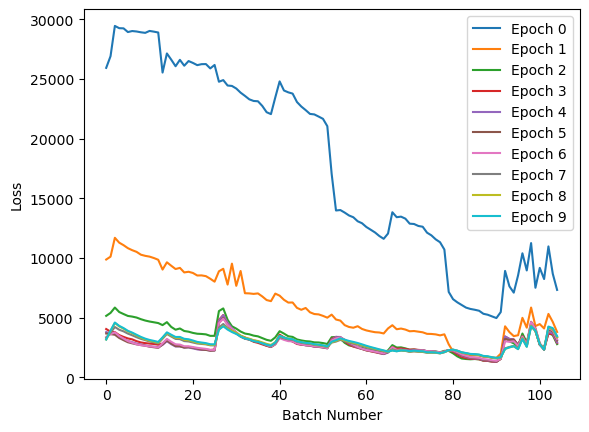

104
209
314
419
524
629
734
839
944
1049


Text(0.5, 0, 'Epoch Index')

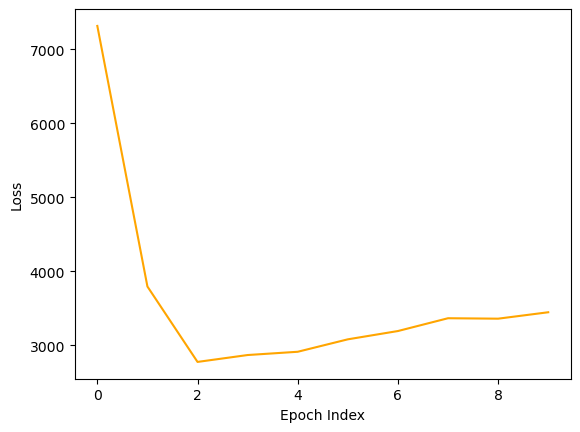

In [6]:
loss_list
original_list=loss_list.copy()
epoch_batch_loss=[]
for x in range(num_epochs):
    temp_loss=[]
    temp_batch_number=[]
    for line in loss_list:
        if x == line[2]:
            temp_loss.append(line[0])
            temp_batch_number.append(line[1])
    epoch_batch_loss.append([x,temp_loss,temp_batch_number])

import matplotlib.pyplot as plt
for x in epoch_batch_loss:
    plt.plot(x[2],x[1],label="Epoch "+str(x[0]))
plt.ylabel("Loss")
plt.xlabel("Batch Number")
plt.legend()
plt.show()


loss_y=[]
epoch_x=[]
i=1
while i*105-1<len(loss_list):
   index=105*i-1
   loss_y.append(loss_list[index][0])
   epoch_x.append(loss_list[index][2])
   print(index)
   i=i+1


plt.plot(epoch_x,loss_y,color='orange')
plt.ylabel("Loss")
plt.xlabel("Epoch Index")